# Web App Demonstrating OpenAI's Whisper Speech Recognition Model

This is a Colab notebook that allows you to record or upload audio files to [OpenAI's free Whisper speech recognition model](https://openai.com/blog/whisper/). This was based on [an original notebook by @amrrs](https://github.com/amrrs/openai-whisper-webapp), with added documentation and test files by [Pete Warden](https://twitter.com/petewarden).

To use it, choose `Runtime->Run All` from the Colab menu. If you're viewing this notebook on GitHub, follow [this link](https://colab.research.google.com/github/petewarden/openai-whisper-webapp/blob/main/OpenAI_Whisper_ASR_Demo.ipynb) to open it in Colab first. After about a minute or so, you should see a button at the bottom of the page with a `Record from microphone` link. Click this, you'll be asked to give permission to access your mic, and then speak for up to 30 seconds. Once you're done, press `Stop recording`, and a transcript of the first 30 seconds of your speech should soon appear in the box to the right of the recording button. To transcribe more speech, click `Clear' in the left box and start over.

You can also upload your own audio samples using the folder icon on the left of this page. That gives you access to a file system you can upload to by dragging files into it. You can see examples of how to run the transcription in a couple of the cells below.

## Install the Whisper Code

In [1]:
! pip install git+https://github.com/openai/whisper.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00


## Load the ML Model

In [2]:
import whisper

model = whisper.load_model("base")


100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 109MiB/s]


## Check we have a GPU

You should see the output `device(type='cuda', index=0)` below. If you don't, you may be on a CPU-only Colab instance which will run more slowly. Go to `Runtime->Change Runtime Type` to fix this.

In [3]:
model.device

device(type='cuda', index=0)

## Download Test Audio Files

This repository has a couple of pre-recorded MP3s to run through the transcribe function. You can listen to them with the audio widgets displayed below.

In [4]:
!git clone https://github.com/petewarden/openai-whisper-webapp

Cloning into 'openai-whisper-webapp'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 33 (delta 11), reused 30 (delta 9), pack-reused 1
Receiving objects: 100% (33/33), 1.40 MiB | 4.48 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
from IPython.display import Audio
Audio("/content/openai-whisper-webapp/mary.mp3")

In [ ]:
from IPython.display import Audio
Audio("/content/openai-whisper-webapp/daisy_HAL_9000.mp3")

## Define the Transcribe Function

Now we've loaded the model, and have the code, this is the function that takes an audio file path as an input and returns the recognized text (and logs what it thinks the language is).

In [5]:
def transcribe(audio):

    # load audio and pad/trim it to fit 30 seconds
    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)

    # make log-Mel spectrogram and move to the same device as the model
    mel = whisper.log_mel_spectrogram(audio).to(model.device)

    # detect the spoken language
    _, probs = model.detect_language(mel)
    print(f"Detected language: {max(probs, key=probs.get)}")

    # decode the audio
    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    return result.text


## Test with Pre-Recorded Audio

Before we bring up the UI to allow you to record your own live audio, we're going to run the `transcribe()` function on a couple of MP3s we've downloaded. You should see `Mary had a little lamb, its fleece was white as snow, and everywhere that Mary went, the lamb was sure to go.` for `mary.mp3`, which I recorded as an example of clear audio. The second file is a lot harder to transcribe, with very distorted audio, but the model does a good job with `Tazy, Tazy, Tazy. Give me your answer to time after crazy all for the love of you. It won't be a stylish marriage`. You'll notice the transcript is cut off after 30 seconds, which is the default length for this notebook. It can be extended, but that's outside of the scope of this documentation.

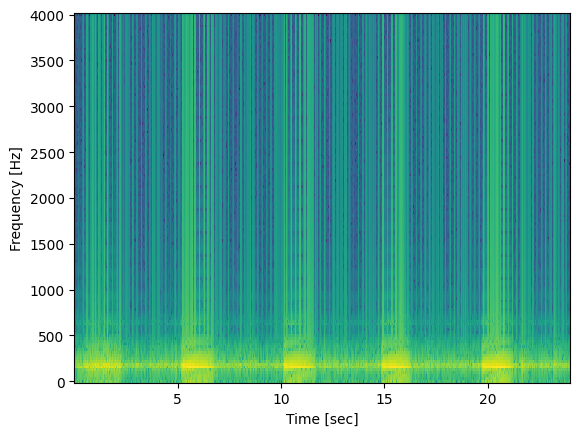

In [16]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np

sample_rate, samples = wavfile.read('/content/nepblue24s10x.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, np.log(spectrogram))
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [18]:
import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

<ipython-input-18-21fda455a8a4>:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  sound_info = pylab.fromstring(frames, 'int16')


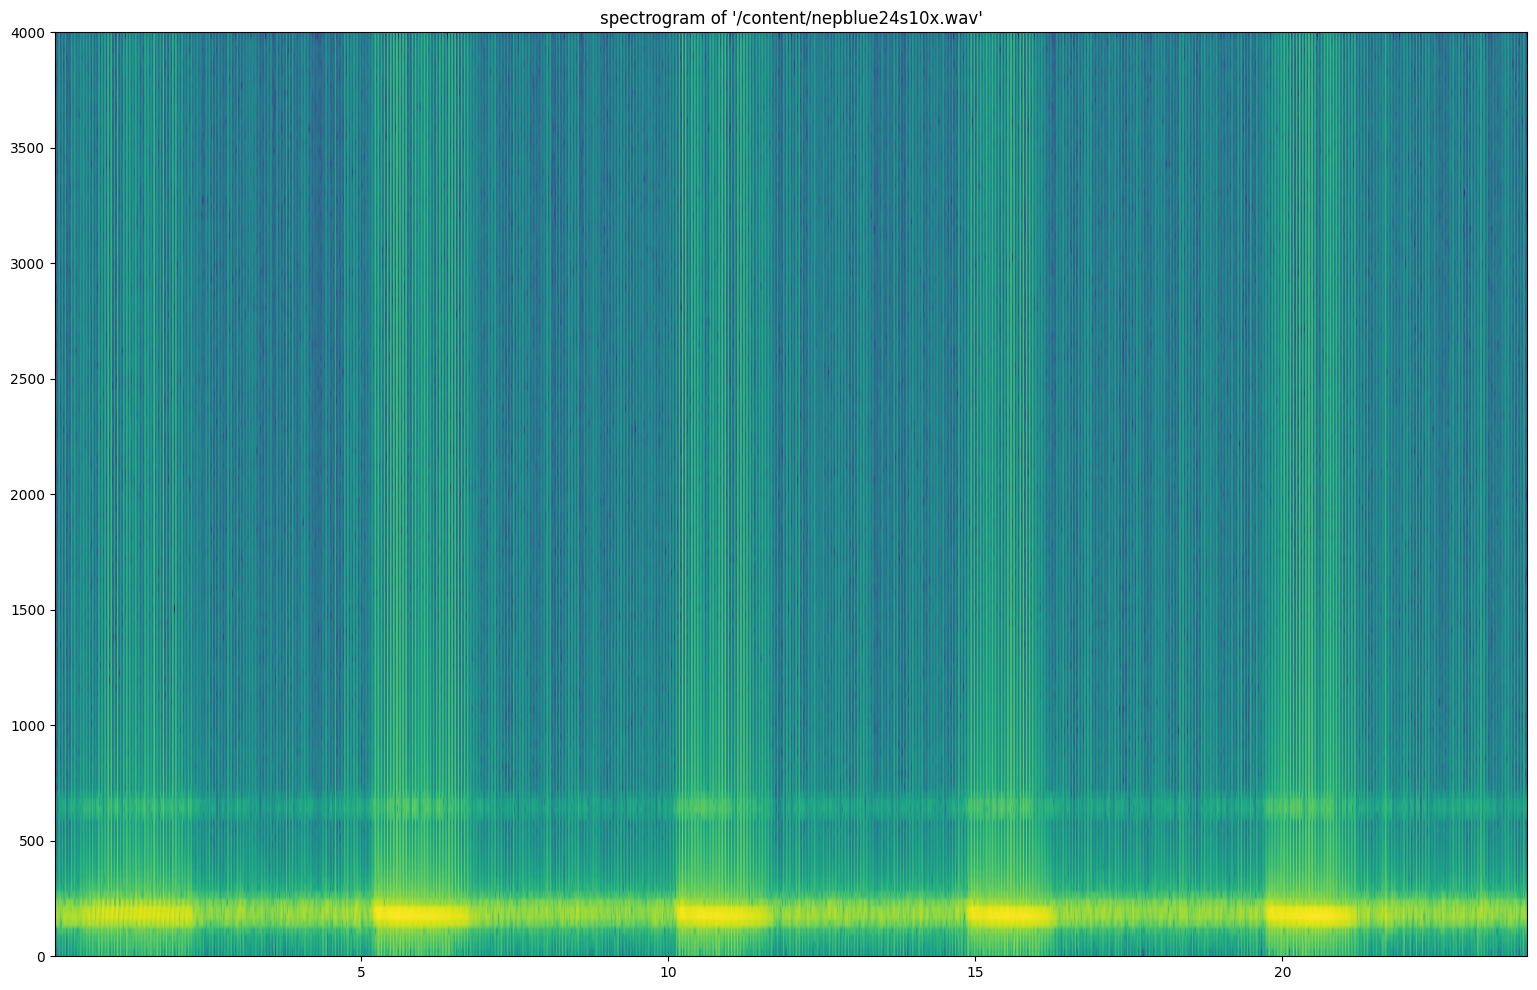

In [19]:
graph_spectrogram('/content/nepblue24s10x.wav')

In [8]:
from IPython.display import Audio
Audio("/content/nepblue24s10x.wav")

In [9]:
easy_text = transcribe("/content/nepblue24s10x.wav")
print(easy_text)


Detected language: en
Thank you.


In [7]:
easy_text = transcribe("/content/nepblue24s10x.wav")
print(easy_text)

hard_text = transcribe("/content/openai-whisper-webapp/daisy_HAL_9000.mp3")
print(hard_text)

Detected language: en
Thank you.
Detected language: en
Tazy, Tazy, Tazy. Give me your answer to time after crazy all for the love of you. It won't be a stylish marriage


## Install the Web UI Toolkit

We'll be using gradio to provide the widgets we need to do audio recording.

In [ ]:
! pip install gradio -q

     |████████████████████████████████| 5.3 MB 32.6 MB/s 
     |████████████████████████████████| 2.3 MB 51.5 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 270 kB 76.5 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 57 kB 4.7 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 64.5 MB/s 
     |████████████████████████████████| 212 kB 72.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 80 kB 7.7 MB/s 
     |████████████████████████████████| 68 kB 6.2 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 4.0 MB 60.8 MB/s 
     |████████████████████████████████| 594 kB 70.8 MB/s 
     |████████████████████████████████| 856 kB 61.2 MB/s 


In [ ]:
import gradio as gr
import time

## Web Interface

After running this script, you should see two widgets below that you can use to record live audio and see the transcription, as described in the introduction.

In [ ]:

gr.Interface(
    title = 'OpenAI Whisper ASR Gradio Web UI',
    fn=transcribe,
    inputs=[
        gr.inputs.Audio(source="microphone", type="filepath")
    ],
    outputs=[
        "textbox"
    ],
    live=True).launch()

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:319: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Hint: Set streaming=True for Audio component to use live streaming.
Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
Running on public URL: https://23121.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f399e32da50>,
 'http://127.0.0.1:7860/',
 'https://23121.gradio.app')